In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, auc, roc_auc_score

from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RepeatedKFold, learning_curve

In [8]:
df = pd.read_csv("US_Accidents_Dec20_updated_cleaned_imputed_data_prepared.csv")

In [9]:
X, y = df.drop(["Severity"], axis=1), df["Severity"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
cols_to_scale = ["Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]

In [13]:
scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

<ipython-input-13-22cd63f610dd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
/home/luay/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-13-22cd63f610dd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



# Decision tree

In [18]:
unique_classes = np.unique(y_train)
dtr_class_weight = {(key+1): value for key, value in enumerate(compute_class_weight("balanced", unique_classes, y_train))}

In [19]:
dtr_hyperparams = {
    "criterion": ["gini", "entropy"], 
    "max_depth": [4, 5, 6], 
}

In [21]:
dtr_model = DecisionTreeClassifier(class_weight=dtr_class_weight, random_state=0)
gscv = GridSearchCV(dtr_model, dtr_hyperparams, n_jobs=-1)
gscv.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(class_weight={1: 13.428971610788786,
                                                            2: 0.31260271020926594,
                                                            3: 2.3509602710623847,
                                                            4: 3.319750700709468},
                                              random_state=0),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6]})

In [22]:
gscv.best_params_

{'criterion': 'gini', 'max_depth': 6}

In [23]:
best_estimator = gscv.best_estimator_

In [25]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, 
                        train_sizes=np.linspace(0.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 1)

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y,
        cv=cv,
        scoring='r2', 
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")
    return plt


In [32]:
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=0)

<module 'matplotlib.pyplot' from '/home/luay/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

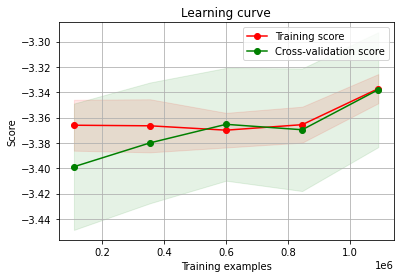

In [33]:
plot_learning_curve(best_estimator, "Learning curve", X_train, y_train, axes=None, ylim=None, cv=rkf, 
                        train_sizes=np.linspace(0.1, 1.0, 5))

In [42]:
dtr_model_best = DecisionTreeClassifier(**gscv.best_params_, class_weight=dtr_class_weight, random_state=0)

In [43]:
dtr_model_best.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={1: 13.428971610788786,
                                     2: 0.31260271020926594,
                                     3: 2.3509602710623847,
                                     4: 3.319750700709468},
                       max_depth=6, random_state=0)

In [41]:
y_pred = dtr_model_best.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_micro = f1_score(y_test, y_pred, average="micro")
roc_auc = roc_auc_score(y_test, dtr_model_best.predict_proba(X_test), multi_class="ovr")
print(f"Accuracy: {acc}, F1 (macro): {f1_macro}, F1 (micro): {f1_micro}, AUC: {roc_auc}")

Accuracy: 0.3596514661310696, F1 (macro): 0.2476509517265685, F1 (micro): 0.3596514661310696, AUC: 0.6690365487528689
